In [36]:
# Import libraries
from collections import Counter

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

import pickle


## Load Dataset

In [37]:
df = pd.read_csv("bankloan.csv")
print(f"Dataset size: {df.shape}")
df.head()

Dataset size: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Clean Dataset

In [38]:
df = df.dropna()
df = df.drop(columns="Loan_ID")
print(f"Dataset size: {df.shape}")

Dataset size: (480, 12)


## Dataset Imbalance

In [39]:
df["Loan_Status"].value_counts()

Loan_Status
Y    332
N    148
Name: count, dtype: int64

# One Hot Encoding

In [40]:
y = df["Loan_Status"].map({"Y": 1, "N": 0})
X_pre = pd.get_dummies(df.drop(columns=["Loan_Status"]), dtype=int)

## Balance Dataset

In [42]:
smote = SMOTE(sampling_strategy="minority")
X, y = smote.fit_resample(X_pre, y)
print(f"Balanced Dataset: {dict(Counter(y))}")

Balanced Dataset: {0: 332, 1: 332}


## Scale Dataset

In [43]:
sc = MinMaxScaler()
X = sc.fit_transform(X)

## Test Train Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Model

In [49]:
classifier = Sequential()
classifier.add(Dense(50, activation='relu', kernel_initializer='random_normal', input_dim=X_test.shape[1]))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))
classifier.add(Dense(100, activation='relu', kernel_initializer='random_normal'))
classifier.add(BatchNormalization())
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train, batch_size=10, epochs=100, verbose=0)
print(f"Training: {classifier.evaluate(X_train, y_train)}")
print(f"Test: {classifier.evaluate(X_test, y_test)}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8578 - loss: 0.3409  
Training: [0.32958629727363586, 0.8681732416152954]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8854 - loss: 0.3584 
Test: [0.4056047201156616, 0.8646616339683533]


## Confusion Matrix

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000015AD4BD51C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


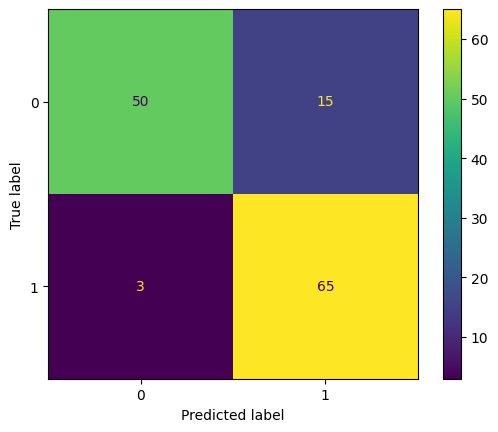

In [50]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

# Save file

In [51]:
filename = "loan_model.pkl"
pickle.dump(classifier, open(filename, 'wb'))